In [18]:
import string
import torch
from torch import nn
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from random import sample
from torch.utils.data import Dataset
plt.style.use('dark_background')

In [3]:
import wget
wget.download('https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt')

100% [........................................................] 262521 / 262521

'onegin (2).txt'

In [26]:
with open('Gachkevich.txt', 'r', encoding="utf8") as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

whole_text = ""

for strin in text:
    whole_text += strin
text = whole_text.lower()

In [5]:
with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

whole_text = ""

for strin in text:
    whole_text += strin
text = whole_text.lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


In [27]:
text

'так непросто плыть, когда\nты не видишь берегов,\nи солёная вода\nбьёт тебя поверх бортов.\nдолго древний человек\nне решался в море плыть\nи спокойный шёпот рек\nшумом моря заменить.\nвспомним мы с тобой сейчас,\nкак в истории земной\nпроложили путь для нас\nа начать хочу рассказ\nя с народов и культур,\nтам возникших, где сейчас\nярко светит сингапур.\nа ещё индокитай -\nздесь для нас ориентир,\nавстронезией тот край\nназовёт научный мир.\nте культуры дали нам\nтри угла у парусов,\nплюс ещё катамаран,\nне боявшийся штормов.\nи народы наугад\nпо недремлющим волнам\nшли пять тысяч лет назад\nк неизвестным островам.\nтонга и калимантан,\nфиджи и мадагаскар:\nк путешествиям был дан\nдревним людям редкий дар.\nдальше шёл за веком век,\nза годами шли года,\nразвивался человек,\nи звала его вода.\nздесь про древних египтян\nмы с тобой поговорим,\nвероятно, океан\nбыл тогда подвластен им,\nно в истории о том\nточных фактов нет пока,\nа вот в море путь знаком\nбыл им в древние века.\nпаруса 

max length = 41


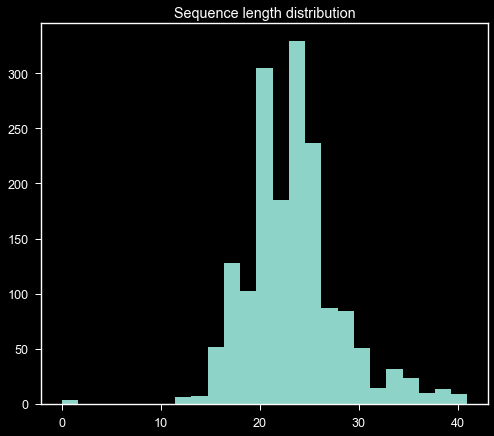

In [28]:
lines = text.split('\n')

MAX_LENGTH = max(map(len, lines))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, lines)),bins=25);

max length = 40


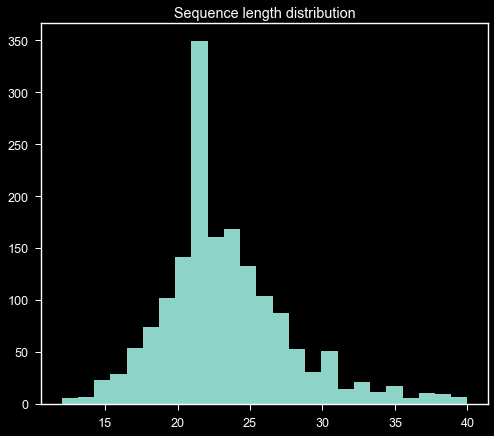

In [29]:
i = 0
len_of_list = len(lines)
while i < len_of_list:
    if len(lines[i]) < 11 or len(lines[i]) > 40:
        lines.remove(lines[i])
        len_of_list = len(lines)
        i-=1
    i+=1
    
MAX_LENGTH = max(map(len, lines))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, lines)),bins=25);

In [32]:
text

'так непросто плыть, когда\n ты не видишь берегов,\n и солёная вода\n бьёт тебя поверх бортов.\n долго древний человек\n не решался в море плыть\n и спокойный шёпот рек\n шумом моря заменить.\n вспомним мы с тобой сейчас,\n как в истории земной\n проложили путь для нас\n а начать хочу рассказ\n я с народов и культур,\n там возникших, где сейчас\n ярко светит сингапур.\n а ещё индокитай -\n здесь для нас ориентир,\n австронезией тот край\n назовёт научный мир.\n те культуры дали нам\n три угла у парусов,\n плюс ещё катамаран,\n не боявшийся штормов.\n и народы наугад\n по недремлющим волнам\n шли пять тысяч лет назад\n к неизвестным островам.\n тонга и калимантан,\n фиджи и мадагаскар:\n к путешествиям был дан\n древним людям редкий дар.\n дальше шёл за веком век,\n за годами шли года,\n развивался человек,\n и звала его вода.\n здесь про древних египтян\n мы с тобой поговорим,\n вероятно, океан\n был тогда подвластен им,\n но в истории о том\n точных фактов нет пока,\n а вот в море пут

In [31]:
text = ''
for k in lines:
    text=text + k +'\n '

In [33]:
class Model(nn.Module):
    def __init__(self, dataset):
        super(Model, self).__init__()
        self.lstm_size = 400
        self.embedding_dim = 200
        self.num_layers = 3
        n_vocab = len(dataset.uniq_words)
        self.embedding = nn.Embedding(num_embeddings=n_vocab, embedding_dim=self.embedding_dim,)
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.fc = nn.Linear(self.lstm_size, n_vocab)
    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits, state
    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size))

In [34]:
class Dataset(Dataset):
    def __init__(self, text):
        self.seq_len = 5
        self.max_epochs = 50
        self.text = text
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()
        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}
        self.words_indexes = [self.word_to_index[w] for w in self.words]
    def load_words(self):
        inp = self.text.split(' ')
        out = ''
        for word in inp:
            if (word != '\n') and (word != ''):
                out = out + word + ' '
            elif word == '\n':
                out+='\n'
        return out.split(' ')
    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)
    def __len__(self):
        return len(self.words_indexes) - self.seq_len
    def __getitem__(self, index):
        return (
            torch.tensor(self.words_indexes[index:index+self.seq_len]),
            torch.tensor(self.words_indexes[index+1:index+self.seq_len+1]),
        )

In [35]:
import torch.onnx
device = torch.device("cuda")

In [38]:
from torch import nn, optim
from torch.utils.data import DataLoader
from collections import Counter

def train(dataset, model, device = device):
    seq_len = 5
    max_epochs = 80
    model.train()
    dataloader = DataLoader(dataset, batch_size=256)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    for epoch in range(max_epochs):
        state_h, state_c = model.init_state(seq_len)
        for batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()
            y_pred, (state_h, state_c) = model(x.to(device), (state_h.to(device), state_c.to(device)))
            loss = criterion(y_pred.transpose(1, 2), y.to(device))
            state_h = state_h.detach()
            state_c = state_c.detach()
            loss.backward()
            optimizer.step()
        print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })

In [39]:
def predict(dataset, model, text, next_words=100, temperature=1.0):
    model.eval()
    words = text.split(' ')
    state_h, state_c = model.init_state(len(words))
    for i in range(0, next_words):
        x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]])
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))
        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits/temperature, dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(dataset.index_to_word[word_index])
        text= text + ' ' + dataset.index_to_word[word_index]
    return text

In [50]:
# import argparse
# parser = argparse.ArgumentParser()
# parser.add_argument('--max-epochs', type=int, default=10)
# parser.add_argument('--batch-size', type=int, default=256)
# parser.add_argument('--sequence-length', type=int, default=4)
# args = parser.parse_args()
dataset = Dataset(text)
# model = Model(dataset)
model.to(device)
train(dataset, model)

{'epoch': 0, 'batch': 27, 'loss': 1.9529023170471191}
{'epoch': 1, 'batch': 27, 'loss': 1.9401779174804688}
{'epoch': 2, 'batch': 27, 'loss': 1.8782153129577637}
{'epoch': 3, 'batch': 27, 'loss': 1.8591305017471313}
{'epoch': 4, 'batch': 27, 'loss': 1.8195295333862305}
{'epoch': 5, 'batch': 27, 'loss': 1.8285964727401733}
{'epoch': 6, 'batch': 27, 'loss': 1.778700590133667}
{'epoch': 7, 'batch': 27, 'loss': 1.7642390727996826}
{'epoch': 8, 'batch': 27, 'loss': 1.7322418689727783}
{'epoch': 9, 'batch': 27, 'loss': 1.6772905588150024}
{'epoch': 10, 'batch': 27, 'loss': 1.6764317750930786}
{'epoch': 11, 'batch': 27, 'loss': 1.6477676630020142}
{'epoch': 12, 'batch': 27, 'loss': 1.6296119689941406}
{'epoch': 13, 'batch': 27, 'loss': 1.598889946937561}
{'epoch': 14, 'batch': 27, 'loss': 1.578930139541626}
{'epoch': 15, 'batch': 27, 'loss': 1.5420271158218384}
{'epoch': 16, 'batch': 27, 'loss': 1.548196792602539}
{'epoch': 17, 'batch': 27, 'loss': 1.5121362209320068}
{'epoch': 18, 'batch': 2

In [36]:
def save_checkpoint(path, model):
    state = {'state_dict': model.state_dict()}
    torch.save(state, path)
    print('model saved to %s' % path)
    
def load_checkpoint(path, model):
    state = torch.load(path)
    model.load_state_dict(state['state_dict'])
    print('model loaded from %s' % path)

In [37]:
save_checkpoint("LSTM_Sonet_30epoch.pth", model)

model saved to LSTM_Sonet_30epoch.pth


In [58]:
model_two = Model(dataset)
load_checkpoint("LSTM.pth", model_two)

model loaded from LSTM.pth


In [55]:
model.to('cpu')
print(predict(dataset, model, text=' ', temperature = 2.0))

  поцелую,
 дождливый тому полёт,
 пер вам помогли,
 задержаться вот точно так знал был с найти!
 нужны что океан
 был купцы
 аравии ребята! прекрасно моря плыл - новый синий на любил
 задумчив друг спортивной "гром",
 равных особый морях,
 боях,
 прочь,
 не продолжил русь он цветов,
 солнечное для остановки.
 вместе чёрный долго чают,
 посетить свечи,
 ты на встречаться
 чтобы можно ветров
 я речку мчать стран.
 будет «дружище!»
 - ближе
 -
 со жизнь материков.
 «дайте рим
 за гложет:
 гонят ни же же
 же мной с вернул вас и лица
 показать со там теплее со между тогда
 меры...
 шли так швед
 мне разберись!»
 земель,



In [37]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, text):
        self.text = text
        self.seq_len = 100
        self.max_epochs = 20
        self.chars = self.load_chars()
        self.index_to_word = {index: word for index, word in enumerate(self.chars)}
        self.word_to_index = {word: index for index, word in enumerate(self.chars)}
        self.max_len = (len(text) - 1)//self.seq_len - 1
#         self.words_indexes = [self.word_to_index[w] for w in self.words]
    def load_chars(self):
        return sorted(list(set(self.text)))
    
    def to_matrix(self, line, dtype='int32'):
        """Casts a list of names into rnn-digestable matrix"""
        
        names_ix = np.zeros(self.max_len, dtype) + self.word_to_index[' ']
        names_ix = [self.word_to_index[c] for c in line]
        return names_ix

    def __len__(self):
        return (len(self.text) - 1)//self.seq_len - 1
    def __getitem__(self, index):
        return (
            torch.tensor(self.to_matrix(self.text[index*self.seq_len : (index+1)*self.seq_len - 1])),
            torch.tensor(self.to_matrix(self.text[index*self.seq_len+1:(index+1)*self.seq_len])))

In [38]:
def train(dataset, model, device = device):
    seq_len = 100
    max_epochs = 20
    model.train()
    dataloader = DataLoader(dataset, batch_size=50)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(max_epochs):
        state_h, state_c = model.init_state(seq_len-1)
        for batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()
            y_pred, (state_h, state_c) = model(x.to(device), (state_h.to(device), state_c.to(device)))
            loss = criterion(y_pred.transpose(1, 2), y.to(device))
            state_h = state_h.detach()
            state_c = state_c.detach()
            loss.backward()
            optimizer.step()
        print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })
#         print({ 'epoch': epoch, 'loss': loss.item() })

In [22]:
class Model(nn.Module):
    def __init__(self, dataset):
        super(Model, self).__init__()
        self.lstm_size = 700
        self.embedding_dim = 300
        self.num_layers = 3
        n_vocab = len(dataset.chars)
        self.embedding = nn.Embedding(num_embeddings=n_vocab, embedding_dim=self.embedding_dim,)
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.fc = nn.Linear(self.lstm_size, n_vocab)
    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits, state
    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size))

In [25]:
dataset_two = Dataset(text)
model_char = Model(dataset_two)

In [39]:
# dataset_two = Dataset(text)
# model_char = Model(dataset_two)
model_char.to(device)
train(dataset_two, model_char)

{'epoch': 0, 'batch': 28, 'loss': 0.09682273864746094}
{'epoch': 1, 'batch': 28, 'loss': 0.10240859538316727}
{'epoch': 2, 'batch': 28, 'loss': 0.08513367921113968}
{'epoch': 3, 'batch': 28, 'loss': 0.08738216757774353}
{'epoch': 4, 'batch': 28, 'loss': 0.09647074341773987}
{'epoch': 5, 'batch': 28, 'loss': 0.079768106341362}
{'epoch': 6, 'batch': 28, 'loss': 0.08387468010187149}
{'epoch': 7, 'batch': 28, 'loss': 0.08808144927024841}
{'epoch': 8, 'batch': 28, 'loss': 0.07524663954973221}
{'epoch': 9, 'batch': 28, 'loss': 0.08898662775754929}
{'epoch': 10, 'batch': 28, 'loss': 0.07335591316223145}
{'epoch': 11, 'batch': 28, 'loss': 0.06725605577230453}
{'epoch': 12, 'batch': 28, 'loss': 0.06719626486301422}
{'epoch': 13, 'batch': 28, 'loss': 0.07358170300722122}
{'epoch': 14, 'batch': 28, 'loss': 0.07715991884469986}
{'epoch': 15, 'batch': 28, 'loss': 0.07090272754430771}
{'epoch': 16, 'batch': 28, 'loss': 0.06342017650604248}
{'epoch': 17, 'batch': 28, 'loss': 0.06325935572385788}
{'ep

In [28]:
def predict(dataset, model, text, next_words=500, temperature=1.0):
    model.eval()
    
    state_h, state_c = model.init_state(len(text))
    for i in range(0, next_words):
        x = torch.tensor([[dataset.word_to_index[w] for w in text[i:]]])
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))
        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits/temperature, dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
#         words.append(dataset.index_to_word[word_index])
        text= text + dataset.index_to_word[word_index]
    return text

In [42]:
model_char.to('cpu')
print(predict(dataset_two, model_char, text=' ', temperature = 0.9))

 лоновымавапраружнань, тв; погого ро дцажатог м ок да ени «ноннам им, по с здидот жни рогонналивый тол вилож прерало ить,
 и ль,
 ов да том – пре оный погой д лельетовелоть х орук реслитрносласей не набужнеруздира бодазд блу,
 там уз быкаказе стстогомежнатд, ивомец,
 сум у.
 купреното туми ноного х окий
 бого с не ом нут;
 оствот дуки сск;
 поко когель жеградерость…
 с имостый т, н мна; бле са то х о е, а певове тода
 илолсь,
 вавгровши ся ла тно ит поготол вий косправ, «ныналамо поероре у у и ми


In [43]:
save_checkpoint("LSTM_Ru2.pth", model_char)

model saved to LSTM_Ru2.pth


In [33]:
load_checkpoint("LSTM_Ru2.pth", model_char)

model loaded from LSTM_Ru2.pth
